# Visualize

# Reconstruction of the diffusion signal with the Tensor model

The diffusion tensor model is a model that describes the diffusion within a
voxel. First proposed by Basser and colleagues [Basser1994]_, it has been very
influential in demonstrating the utility of diffusion MRI in characterizing the
micro-structure of white matter tissue and of the biophysical properties of
tissue, inferred from local diffusion properties and it is still very commonly
used.

The diffusion tensor models the diffusion signal as:
\\[\frac{S(\mathbf{g}, b)}{S_0} = e^{-b\mathbf{g}^T \mathbf{D} \mathbf{g}}\\]

Where $\mathbf{g}$ is a unit vector in 3 space indicating the direction of
measurement and b are the parameters of measurement, such as the strength and
duration of diffusion-weighting gradient. $S(\mathbf{g}, b)$ is the
diffusion-weighted signal measured and $S_0$ is the signal conducted in a
measurement with no diffusion weighting. $\mathbf{D}$ is a positive-definite
quadratic form, which contains six free parameters to be fit. These six
parameters are:

\\[
   \mathbf{D} = \begin{pmatrix} D_{xx} & D_{xy} & D_{xz} \\
                       D_{yx} & D_{yy} & D_{yz} \\
                       D_{zx} & D_{zy} & D_{zz} \\ \end{pmatrix}
\\]

This matrix is a variance/covariance matrix of the diffusivity along the three
spatial dimensions. Note that we can assume that diffusivity has antipodal
symmetry, so elements across the diagonal are equal. For example:
$D_{xy} = D_{yx}$. This is why there are only 6 free parameters to estimate
here.

In the following example we show how to reconstruct your diffusion datasets
using a single tensor model.

First import the necessary modules:

``numpy`` is for numerical computation


In [1]:
import numpy as np

``dipy.io.image`` is for loading / saving imaging datasets
``dipy.io.gradients`` is for loading / saving our bvals and bvecs

In [2]:
from dipy.io.image import load_nifti, save_nifti
from dipy.io.gradients import read_bvals_bvecs
from dipy.core.gradients import gradient_table

``dipy.reconst`` is for the reconstruction algorithms which we use to create
voxel models from the raw data.

In [3]:
import dipy.reconst.dti as dti

``dipy.data`` is used for small datasets that we use in tests and examples.

In [8]:
from dipy.data import get_fnames
from dipy.data import fetch_sherbrooke_3shell
fetch_sherbrooke_3shell()

from os.path import expanduser, join
home = expanduser('~')
# dname=join(home,'.dipy','sherbrooke_3shell')
dname=join(home,'MIA-Proj/DATA','HCP/LS6046/')

In [9]:
fdwi = join(dname, 'LS6046_3T_DWI_dir80_LR_gdc.nii.gz')

print(fdwi)

fbval = join(dname, 'LS6046_3T_DWI_dir80_LR.bval')

print(fbval)

fbvec = join(dname, 'LS6046_3T_DWI_dir80_LR.bvec')

print(fbvec)

from dipy.io.image import load_nifti
data, affine, img = load_nifti(fdwi, return_img=True)

/home/zhiyunl/MIA-Proj/DATA/HCP/LS6046/LS6046_3T_DWI_dir80_LR_gdc.nii.gz
/home/zhiyunl/MIA-Proj/DATA/HCP/LS6046/LS6046_3T_DWI_dir80_LR.bval
/home/zhiyunl/MIA-Proj/DATA/HCP/LS6046/LS6046_3T_DWI_dir80_LR.bvec


``get_fnames`` will download the raw dMRI dataset of a single subject.
The size of the dataset is 87 MBytes. You only need to fetch once. It
will return the file names of our data.

In [10]:
# check dimension of each voxel
print(img.header.get_zooms()[:3])

(1.5, 1.5, 1.5000007)


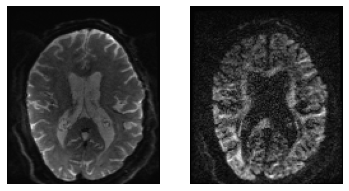

<Figure size 432x288 with 0 Axes>

In [11]:
# visualize middle slice
import matplotlib.pyplot as plt

axial_middle = data.shape[2] // 2
plt.figure('Showing the datasets')
plt.subplot(1, 2, 1).set_axis_off()
# without diffusion weighting
plt.imshow(data[:, :, axial_middle, 0].T, cmap='gray', origin='lower')
plt.subplot(1, 2, 2).set_axis_off()
# with dw
plt.imshow(data[:, :, axial_middle, 10].T, cmap='gray', origin='lower')
plt.show()
plt.savefig('data.png', bbox_inches='tight')

In [12]:
bvals, bvecs = read_bvals_bvecs(fbval, fbvec)
gtab = gradient_table(bvals, bvecs)
# use gtab to get S0s
S0s = data[:, :, :, gtab.b0s_mask]
print(S0s.shape)
# save

(120, 140, 93, 5)


In [ ]:
hardi_fname, hardi_bval_fname, hardi_bvec_fname = get_fnames('stanford_hardi')
# hardi_fname = "/~/MIA_porj/"
print(hardi_fname,hardi_bval_fname,hardi_bvec_fname)

Next, we read the saved dataset. gtab contains a ``GradientTable``
object (information about the gradients e.g. b-values and b-vectors).

In [ ]:
data, affine = load_nifti(hardi_fname)

bvals, bvecs = read_bvals_bvecs(hardi_bval_fname, hardi_bvec_fname)
gtab = gradient_table(bvals, bvecs)
# data is a 4D array, first 3 dimensions are i,j,k voxel coordinates, 
# last is # of non-weighted (S_0) and diffusion-weighted volumes.
print('data.shape (%d, %d, %d, %d)' % data.shape)

First of all, we mask and crop the data. This is a quick way to avoid
calculating Tensors on the background of the image. This is done using DIPY_'s
``mask`` module.

In [13]:
from dipy.segment.mask import median_otsu

maskdata, mask = median_otsu(data, vol_idx=range(10, 50), median_radius=3,
                             numpass=1, autocrop=True, dilate=2)
print('maskdata.shape (%d, %d, %d, %d)' % maskdata.shape)

maskdata.shape (103, 126, 92, 80)


Now that we have prepared the datasets we can go forward with the voxel
reconstruction. First, we instantiate the Tensor model in the following way.

In [14]:
tenmodel = dti.TensorModel(gtab)
tenfit = tenmodel.fit(maskdata)

The fit method creates a ``TensorFit`` object which contains the fitting
parameters and other attributes of the model. For example we can generate
fractional anisotropy (FA) from the eigen-values of the tensor. FA is used to
characterize the degree to which the distribution of diffusion in a voxel is
directional. That is, whether there is relatively unrestricted diffusion in one
particular direction.

Mathematically, FA is defined as the normalized variance of the eigen-values of
the tensor:

\\[
        FA = \sqrt{\frac{1}{2}\frac{(\lambda_1-\lambda_2)^2+(\lambda_1-
                    \lambda_3)^2+(\lambda_2-\lambda_3)^2}{\lambda_1^2+
                    \lambda_2^2+\lambda_3^2}}\\]
Note that FA should be interpreted carefully. It may be an indication of the
density of packing of fibers in a voxel, and the amount of myelin wrapping
these axons, but it is not always a measure of "tissue integrity". For example,
FA may decrease in locations in which there is fanning of white matter fibers,
or where more than one population of white matter fibers crosses.

In [15]:
print('Computing anisotropy measures (FA, MD, RGB)')
from dipy.reconst.dti import fractional_anisotropy, color_fa

FA = fractional_anisotropy(tenfit.evals)

Computing anisotropy measures (FA, MD, RGB)


In the background of the image the fitting will not be accurate there is no
signal and possibly we will find FA values with nans (not a number). We can
easily remove these in the following way.

In [16]:
FA[np.isnan(FA)] = 0


In [17]:
print(FA.shape)

(103, 126, 92)


Saving the FA images is very easy using nibabel_. We need the FA volume and the
affine matrix which transform the image's coordinates to the world coordinates.
Here, we choose to save the FA in ``float32``.

In [18]:
save_nifti('tensor_fa.nii.gz', FA.astype(np.float32), affine)

You can now see the result with any nifti viewer or check it slice by slice
using matplotlib_'s ``imshow``. In the same way you can save the eigen values,
the eigen vectors or any other properties of the tensor.

In [19]:
save_nifti('tensor_evecs.nii.gz', tenfit.evecs.astype(np.float32), affine)

Other tensor statistics can be calculated from the ``tenfit`` object. For
example, a commonly calculated statistic is the mean diffusivity (MD). This is
simply the mean of the  eigenvalues of the tensor. Since FA is a normalized
measure of variance and MD is the mean, they are often used as complimentary
measures. In DIPY, there are two equivalent ways to calculate the mean
diffusivity. One is by calling the ``mean_diffusivity`` module function on the
eigen-values of the ``TensorFit`` class instance:

In [20]:
MD1 = dti.mean_diffusivity(tenfit.evals)
save_nifti('tensors_md.nii.gz', MD1.astype(np.float32), affine)

The other is to call the ``TensorFit`` class method:

In [21]:
MD2 = tenfit.md

Obviously, the quantities are identical.

We can also compute the colored FA or RGB-map [Pajevic1999]_. First, we make
sure that the FA is scaled between 0 and 1, we compute the RGB map and save it.

In [22]:
FA = np.clip(FA, 0, 1)
RGB = color_fa(FA, tenfit.evecs)
save_nifti('tensor_rgb.nii.gz', np.array(255 * RGB, 'uint8'), affine)

In [23]:
print(RGB.shape)

(103, 126, 92, 3)


(103, 126)


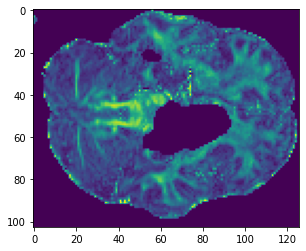

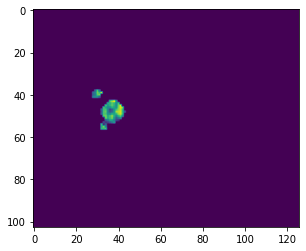

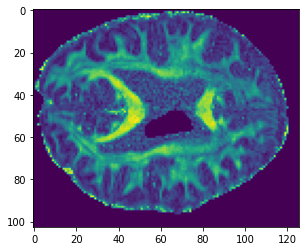

In [38]:
print(FA[:,:,50].shape)
plt.imshow(FA[:,:,25]*255)
plt.show()

plt.imshow(FA[:,:,1]*255)
plt.show()

plt.imshow(FA[:,:,50]*255)
plt.show()

Let's try to visualize the tensor ellipsoids of a small rectangular
area in an axial slice of the splenium of the corpus callosum (CC).

In [39]:
print('Computing tensor ellipsoids in a part of the splenium of the CC')

from dipy.data import get_sphere
sphere = get_sphere('repulsion724')

from dipy.viz import window, actor

# Enables/disables interactive visualization
interactive = True

ren = window.Scene()

evals = tenfit.evals[13:43, 44:74, 28:29]
evecs = tenfit.evecs[13:43, 44:74, 28:29]

Computing tensor ellipsoids in a part of the splenium of the CC


We can color the ellipsoids using the ``color_fa`` values that we calculated
above. In this example we additionally normalize the values to increase the
contrast.

In [40]:
cfa = RGB[13:43, 44:74, 28:29]
cfa /= cfa.max()

ren.add(actor.tensor_slicer(evals, evecs, scalar_colors=cfa, sphere=sphere,
                            scale=0.3))

print('Saving illustration as tensor_ellipsoids.png')
window.record(ren, n_frames=1, out_path='tensor_ellipsoids.png',
              size=(600, 600))
if interactive:
    window.show(ren)

Saving illustration as tensor_ellipsoids.png


In [ ]:
window.clear(ren)

Finally, we can visualize the tensor Orientation Distribution Functions
for the same area as we did with the ellipsoids.

In [41]:
tensor_odfs = tenmodel.fit(data[20:50, 55:85, 38:39]).odf(sphere)

odf_actor = actor.odf_slicer(tensor_odfs, sphere=sphere, scale=0.5,
                             colormap=None)
ren.add(odf_actor)
print('Saving illustration as tensor_odfs.png')
window.record(ren, n_frames=1, out_path='tensor_odfs.png', size=(600, 600))
if interactive:
    window.show(ren)

Saving illustration as tensor_odfs.png


Note that while the tensor model is an accurate and reliable model of the
diffusion signal in the white matter, it has the drawback that it only has one
principal diffusion direction. Therefore, in locations in the brain that
contain multiple fiber populations crossing each other, the tensor model may
indicate that the principal diffusion direction is intermediate to these
directions. Therefore, using the principal diffusion direction for tracking in
these locations may be misleading and may lead to errors in defining the
tracks. Fortunately, other reconstruction methods can be used to represent the
diffusion and fiber orientations in those locations. These are presented in
other examples.